# 2: Clustering

## 1. K-means 

We will start by clustering the documents in three Brown categories: adventure, government and news.

We generate a dataset containing all documents from each category and investigate how well clusters generated by k-means correspond to the original categories.

We will represent each document as a 2-dimensional vector using the function `get_features`:
```
[mean_token_length, frequency_of_"said"]
```

In [1]:
def get_features(document):
    token_length = sum([len(word) for word in document if word.isalpha()])
    said_count= len([word for word in document if word.lower() == "said"])
    
    text_length = len([word for word in document if word.isalpha()])

    return [token_length/text_length, said_count/text_length]

This is a small helper function which just plots the data for us:

In [2]:
import matplotlib.pyplot as plt

WIDTH=5
HEIGHT=6

def plot(X, color_list, centroids):
    """
    Helper fucntion for plotting the output clusters
    """
    plt.figure(figsize=(WIDTH,HEIGHT))
    plt.scatter(X[:,0],X[:,1],color=color_list)
    plt.scatter(centroids[:,0],centroids[:,1],color=COLORS,s=250, marker = '*')
    plt.xlabel("Word length", fontdict={'fontsize':10})
    plt.ylabel("Said frequency", fontdict={'fontsize':10})
    plt.show()

Let's then read the documents in our three Brown categories, convert them to feature vectors and plot the result. We'll use a very simple function `get_features` for converting documents into 2-dimensional vectors:

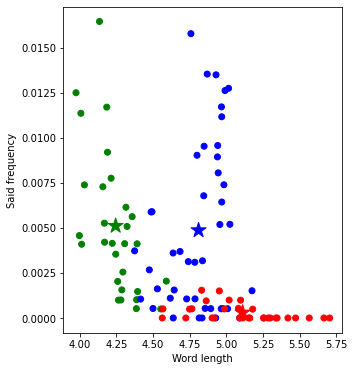

In [3]:
import numpy as np
from nltk.corpus import brown

CATEGORIES = ["adventure","news","government"]
COLORS = ["green", 'blue', 'red']
    
# Generate a list of data points and the color coded gold standard 
# category for each data point.  
data = []
color_list = []

# We'll compute the centroid of each category and plot those too.
centroids = np.zeros((3,2))

for i, category in enumerate(CATEGORIES):
    for fileid in brown.fileids(category):
        color_list.append(COLORS[i])
        data.append(get_features(brown.words(fileid)))    # 2-dimensional data
        centroids[i,:] += data[-1]

# Compute average of all data points in a given category
for i in range(len(COLORS)):
    centroids[i,:] /= color_list.count(COLORS[i])   # count how many words a certain category has
    
# Plot data using pyplot
X = np.array(data)
plot(X, color_list, centroids)

We'll then fit a `sklearn.cluster.KMeans` clustering to the data. We generate 3 clusters, running k-means for a maximum of 100 iterations.

The resulting `kmeans` object has two fields which are important for us:

`kmeans.labels_`: A list of length `number_of_data_points`. It gives the cluster label for each data point.

`kmeans.cluster_centers_`: An array of size `vector_dim x number_of_clusters`. It gives the centroid for each cluster.



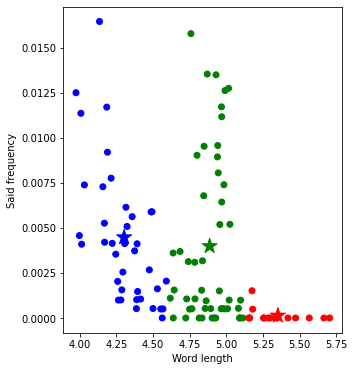

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(max_iter=100, n_clusters=3, random_state=0).fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
color_list = [COLORS[label] for label in labels]

plot(X, color_list, centroids)

### Elbow:

Now run k-means with different cluster sizes (1 .. 10) and use the `plot_elbow` function to plot the losses and the elbow. 

The function takes a list of 10 distortion losses as input and the elbow cluster size and plots them in a graph. Given an `sklearn.cluster.KMeans` object `kmeans` which has been fit on some data, the distortion loss is given by the member `kmeans.inertia_`. 

Try to find a good elbow.

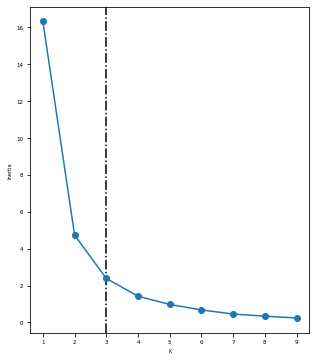

In [5]:
def plot_elbow(losses, elbow):
    """
    Given code for plotting elbow graph.
    """
    plt.figure(figsize = (WIDTH, HEIGHT))
    plt.axvline(x=elbow, linestyle='-.', c="black")
    plt.plot(range(1,10),[loss for loss in losses], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(WIDTH+HEIGHT)/2)
    ax.set_xlabel('K', fontsize=WIDTH)
    ax.set_ylabel("Inertia", fontsize=WIDTH)

losses = []
for k in range(1,10):
    # Fit k-means with k clusters on the dataset X. 
    # The fit function will return a distortion loss which you should append to losses. 
    # You can use max_iter=100 and random_state=0 when initializing KMeans.
    
    losses.append(KMeans(n_clusters = k).fit(X).inertia_)
    
# Plot the elbow graph. Try to find a good value for the elbow.
plot_elbow(losses, 3)

## 2. Hierarchical clustering

We will now run hierarchical clustering on the Brown corpus categories.

We will start by using hierarchical clustering in exactly the same way as k-means clustering, namely to produce a set of n distinct clusters. 

We will represent each category as a bag-of-words and use `sklearn.feature_extraction.DictVectorizer` to covnert them into feature vectors. 

We will first normalize our vectors using `sklearn.preprocessing.normalize` because different categories have unequal size and we don't want this to influence our clustering.

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from collections import Counter
from nltk.corpus import brown,stopwords

en_stopwords = set(stopwords.words("english"))

def preprocess(words):
    """
    Remove stop words and ilter out all numbers and punctuation.
    """
    return [word.lower() for word in words 
            if word.lower() not in en_stopwords and word.isalpha()]

# Use DictVectorizer to produce bag-of-words features for all
# Brown categories
raw_feature_dicts = []
for category in brown.categories():
    raw_feature_dicts.append(Counter(preprocess(brown.words(categories=category))))

vectorizer = DictVectorizer()
X =  normalize(vectorizer.fit_transform(raw_feature_dicts).toarray())

> notice that this is a dict, and `vectorizer.fit_transform` takes in a mapping dict
raw_feature_dicts

```
[Counter({'dan': 23,
          'morgan': 28,
          'told': 46,
          'would': 194,
          'forget': 3,
          'ann': 4,
          'turner': 1,
          ...
```

We'll been using the default linkage criterion for `AgglomerativeClustering` which is `ward`. This is a linkage criterion which doesn't directly minimize the distance between two clusters but instead minimizes the variance of the distances inside clusters. Intuitively it tries to form clusters with roughly even density. 

We will generate 4 clusters here. These are just the last four clusters generated during hierarchical clustering.

In [10]:
agglo = AgglomerativeClustering(n_clusters=4)
agglo.fit(X)


clusters = [[] for k in range(agglo.n_clusters_)]
for category, cluster in zip(brown.categories(), agglo.labels_):
    clusters[cluster].append(category)
    
for cluster in clusters:
    print(cluster)

['belles_lettres', 'editorial', 'lore', 'news', 'religion', 'reviews']
['adventure', 'fiction', 'humor', 'mystery', 'romance', 'science_fiction']
['hobbies', 'learned']
['government']


In [11]:
agglo.labels_

array([1, 0, 0, 1, 3, 2, 1, 2, 0, 1, 0, 0, 0, 1, 1])

The most natural way to view the output of hierarchical clustering is a dendrogram. We'll use the following code to plot the dendrogram.

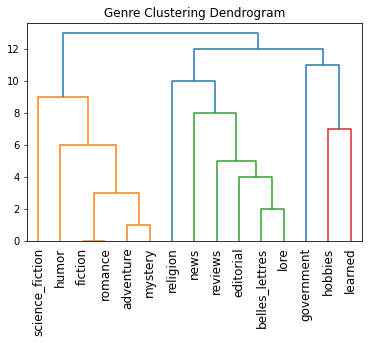

In [12]:
from scipy.cluster.hierarchy import dendrogram

def print_dendogram(agglo):
    children = agglo.children_
    fake_distances = np.arange(children.shape[0])
    fake_no_of_observations = np.arange(children.shape[0])
    linkage_matrix = np.column_stack([children, fake_distances, fake_no_of_observations]).astype(float)
    plt.title('Genre Clustering Dendrogram')
    dendrogram(linkage_matrix,leaf_rotation=90.0,labels=brown.categories())
    plt.show()
    
print_dendogram(agglo)

To build the dendrogram, we use the `children_` attribute of the clustering object which encodes all nodes in the dendrogram. 

In [13]:
for i, cat in enumerate(brown.categories()):
    print(i,cat)
agglo.children_

0 adventure
1 belles_lettres
2 editorial
3 fiction
4 government
5 hobbies
6 humor
7 learned
8 lore
9 mystery
10 news
11 religion
12 reviews
13 romance
14 science_fiction


array([[ 3, 13],
       [ 0,  9],
       [ 1,  8],
       [15, 16],
       [ 2, 17],
       [12, 19],
       [ 6, 18],
       [ 5,  7],
       [10, 20],
       [14, 21],
       [11, 23],
       [ 4, 22],
       [25, 26],
       [24, 27]])

Here's an explanation for the encoding:

Every entry in `agglo.children_` is a pair `p1, p2` corresponding to one node in the dendrogram. When `pi < len(brown.categories)`, then `pi` refers to a single data point `brown.categories[pi]`. When `pi >= len(brown.categories)`, it refers to another node in the dendrogram which can be found at index `pi - len(brown.categories)` in `agglo.children_`.

> This is actually because hierarchical clustering not only clusters points and points(in the beginning), but also clusters points and clusters, clusters and clusters.

For example:

1. `agglo.children_[0] == [3, 13]`, which refers to the cluster `["fiction", "romance"]`
1. `agglo.children_[1] == [0, 9]`, which refers to the cluster `["adventure", "mystery"]`
1. `agglo.children_[3] == [15, 16]`. Here both entries are `>= len(brown.categories())`, so these refer to clusters `agglo.children_[15 - len(brown.categories)] = agglo.children_[0]` and `agglo.children_[15 - len(brown.categories)] = agglo.children_[1]`. I.e. this node defines the cluster `["fiction", "romance", "adventure", "mystery"]`.

## 3. Other clustering methods

Though  𝑘 -means and agglomerative clustering are two of the most popular, there are several other kinds of clustering, some of which are implemented in sklearn. A few more worth knowing about:

[DBSCAN](https://en.wikipedia.org/wiki/DBSCAN): Identify areas of high density in the data to form clusters
[Mixture Models](https://en.wikipedia.org/wiki/Mixture_model): Provide (potentially soft) clustering of points based on the idea that they are being probabilistically generated from, for instance, a Gaussian distribution (one for each cluster).

The choice of clustering technique ultimately depends on various factors, including the nature of the data (big, noisy?), the speed required, etc.